# 自由課題レポート

## 1 課題概要
　今度使用するデータセットは自分で作成したゲーム環境が生成したエージェント観測データである。Double DQN(Deep Q-Learning)モデルを使用し、エージェントが観測した環境データによって最善な動作を予測する。
## 2 ゲーム環境
### 2.1 ゲーム概要
　Ml-AgentsのサンプルオブジェクトScrollBallを模倣した、ターゲットを追いかけるゲームである。真ん中の球は自機エージェント、正方形はターゲットと設定する。ゲーム開始時にターゲットは自機エージェント以外のゲームエリア内にランダムで生成する。自機は上下左右各方向にコントロールすることができ、リアルにシミュレーションするため、Unityの物理エンジンを使用する。各方向に入力があった場合、直接に一定の速度でその方向に移動するわけではなく、一定な加速度を加えることと設定している。自機エージェントがターゲットと接触するとゲームクリアと判定し、8秒経過もしくはゲームエリアから落ちる場合は失敗判定とする。
### 2.2 観測情報
　エージェントはターゲットの位置、および自機位置のx,z座標が観測できることとする。その他、自機の水平と垂直xz方向の速度と合わせてステップ毎に合計六つのデータが観測できる。
### 2.3 Reward設定
　ステップ毎に環境からRewardが返すことになっている。このステップの操作に評価を行うことである。自機がターゲットに前ステップより近づくとその距離値が正のRewardとしてが戻る、逆に前ステップより遠く離れると離れた距離値が負のRewardとして戻ってくる。ゲーム成功時にもらうRewardが10,失敗するときに-10と設定している。
### 2.4 動作確定
　2種類の動作が存在する、垂直及び水平になる。垂直では-1,0,1三つの値があり、各自下、静止、上と意味する,水平も-1,0,1三つの値があり、各左、静止、右と意味する。
## 3 DoubleDQN
### 3.1 Q-Learning
　Q-Learningはすべての環境状態を十分にサンプリングし、各状態ににQualityが最も高い動作を実行する機械学習手法である。
　Q-Learning試行したすべての環境状態をQ-tableに記録し、その環境状態で試行した動作が環境からもらうRewardをそのQ値として記録する。まだ同様な環境が観測した場合、Q-Tableに記載したQ値が最も高い動作を実行する。だが多くな場合、ゲームの環境状態は無限であり、すべての状況を記録することは難しい、しかもメモリにも大量に消耗する。
### 3.2 DQN(Deep Q-Learning)
　DQNはQ-Tableの代わりにニューラルネットワークを使用して、観測した環境状態から各動作のQ値を予測する。今回使用するDouble DQNの構造及びコードは以下になる。


In [1]:
import mlagents_envs
from mlagents_envs.base_env import ActionTuple
from mlagents_envs.environment import UnityEnvironment

import tensorflow as tf
import tensorflow_addons as tfa
import tensorboard
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
from collections import deque
from IPython.display import clear_output

print("ML-Agents Version :",mlagents_envs.__version__)
print("TensroFlow Version:",tf.__version__)

C:\Users\UCUNI\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


ML-Agents Version : 0.27.0
TensroFlow Version: 2.8.0


In [2]:
# 割り当てに必要なGPUメモリのみを割り当てようとする
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

以下環境を実行する際にディレクトリにすべて半角英数字符号となっていることが必要

In [3]:
# 環境パラメータ
log_dir = "ML-logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
env_path = './ScrollBall-Build/ML-ScrollBall-Sample'
brain_name = 'RollerBallBrain'

# ゲーム環境獲得
env = UnityEnvironment(file_name=env_path, seed=1, side_channels=[])
env.reset()

# 環境スペック獲得
tracked_agent = -1
behavior_specs = env.behavior_specs
behavior_name = list(behavior_specs)[0]
spec = behavior_specs[behavior_name]
observation_specs = spec.observation_specs[0]  # 観測spec
action_spec = spec.action_spec  # 動作spec


ENV_Discrete_ACTION_SIZE = action_spec.discrete_size#　連続的な動作のSize
ENV_Continuous_ACTION_SIZE = action_spec.continuous_size#　離散的な動作のSize
STATE_SIZE = observation_specs.shape[0]# 環境観測データ数
SAVE_STEPS = 100 # SAVE_STEPS毎にNNを保存する
ACTION_SIZE = ENV_Discrete_ACTION_SIZE * 3#トータル動作数、一種類の動作に三つの動作が存在するため、*3とする
MAX_EXP_NUM = 2500 # ExperiencePoolに保存できる最大過去記録数

EPSILON_CUT_STEP = 1300
EPISODES = 500
REPLACE_STEPS = 50
BATCH_SIZE = 256
LEARNING_RATE = 0.0005
GAMMA = 0.9

epsilon = 1
epsilon_min = 0.01

print("ステップ毎に環境観測データ数",STATE_SIZE)
print("ステップ毎に実行可能な動作数",ENV_Discrete_ACTION_SIZE)

ステップ毎に環境観測データ数 6
ステップ毎に実行可能な動作数 2


In [4]:
# Experience Pool
class experiencePool:
    def __init__(self):
        self.exp_pool = deque(maxlen=MAX_EXP_NUM)

    def add(self, state, action, reward, netx_state, done):
        self.exp_pool.append((state, action, reward, netx_state, done))

    def get_random(self, num=1):
        random_index = np.random.choice(len(self.exp_pool), num)
        random_exps = [self.exp_pool[i] for i in random_index]
        return random_exps

    def get_len(self):
        return len(self.exp_pool)

# DQNメソッド
class DQN:
    def __init__(self,load,load_dir):
        self.learning_rate = LEARNING_RATE
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_cut = (1-self.epsilon_min)/EPSILON_CUT_STEP
        self.gamma = GAMMA
        
        if load:
            #既存NNデータをローディングする
            self.epsilon = self.epsilon_min
            main_load_dir = load_dir+"main.h5"
            target_load_dir = load_dir+"target.h5"
            self.main_net,self.target_net = self.loadNN(main_load_dir,target_load_dir)
        else:
            #新規mainとtarget　NNを作成する
            self.main_net = self.build_net()
            self.target_net = self.build_net()
        self.exp_pool = experiencePool()

    # ---------------------------------------------------------------------------------
    def build_net(self):
        # NNを作成
        rectifiedAdam = tfa.optimizers.RectifiedAdam(learning_rate = self.learning_rate,weight_decay = 0.001)
        #Adam = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        neural_net = tf.keras.Sequential()
        neural_net.add(tf.keras.layers.Dense(
            units=128, activation='relu', input_dim=STATE_SIZE))
        neural_net.add(tf.keras.layers.Dense(
            units=256, activation='relu'))
        neural_net.add(tf.keras.layers.Dense(
            units=128, activation='relu'))
        neural_net.add(tf.keras.layers.Dense(
            units=64, activation='relu'))
        neural_net.add(tf.keras.layers.Dense(
            units=ACTION_SIZE, activation='elu'))

        neural_net.compile(optimizer=rectifiedAdam, loss='mse', metrics=['accuracy'])
        
        return neural_net

    def select_action(self, state):
        # 動作Q値を予測と動作選択
        random_num = np.random.sample()
        
        if random_num > self.epsilon:
            # DQNをベースにし、動作を選択する
            predictResult = self.main_net(state).numpy()[0]
            actionX = np.argmax(predictResult[0:3])-1
            actionZ = np.argmax(predictResult[3:])-1
            action = np.array([actionX, actionZ], dtype=np.float32)
            #print("action  = ",action)
        else:
            # ランダムで動作を選択
            actionX = np.random.randint(ACTION_SIZE/2)-1
            actionY = np.random.randint(ACTION_SIZE/2)-1
            action = np.array([actionX, actionY], dtype=np.float32)

        # 缩小epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_cut

        return action

    def training(self):
        # トレーニング開始
        if self.exp_pool.get_len() >= BATCH_SIZE:
            # トレーニング集を獲得
            exp_set = self.exp_pool.get_random(num=BATCH_SIZE)
            exp_state = [data[0] for data in exp_set] # EXP_Poolが記録した当時ラウンドの環境状態
            exp_action = [data[1] for data in exp_set] # そのラウンドで選んだ動作
            exp_reward = [data[2] for data in exp_set] # その動作に応じるreward
            exp_next_state = [data[3] for data in exp_set] # その動作が実行した後の環境状態。
            exp_done = [data[4] for data in exp_set] # 実行後にゲームが終了したか

            exp_state = np.asarray(exp_state).squeeze()
            exp_action = np.asarray(exp_action).squeeze()
            exp_next_state = np.asarray(exp_next_state).squeeze()

            # 各ネットでQ値予測
            target_net_q = self.target_net(exp_next_state).numpy()  # target_NN 未来状況のQ値を予測
            main_net_q = self.main_net(exp_state).numpy()  # main_NN 現在状況のQ値を予測

            # トレーニング用Q値、目標y、
            y = main_net_q.copy()  # (1,6)
            
            # Batch全体インデクス、[0,1,......,BATCH_SIZE]
            batch_index = np.arange(BATCH_SIZE, dtype=np.int32)
            
            # 動作の値(-1,0,1)によってQ値のインデクス(Xは(0,1,2)、Zは(3,4,5),各自Shapeは(1,BATCH_SIZE))を作成
            exp_actionX_index = exp_action[:,0] + 1
            exp_actionZ_index = exp_action[:,1] + 4
            exp_actionX_index = exp_actionX_index.astype(np.int)
            exp_actionZ_index = exp_actionZ_index.astype(np.int)
            
            # target_NNが未来状況によって予測したQ値から　垂直/水平動作各自の最大値Q値を摘出
            fixedX = np.max(target_net_q[:, :3], axis=1) # (batchsize,1)
            fixedZ = np.max(target_net_q[:, -3:], axis=1) # (batchsize,1)
            # そのラウンドで受けたreward+未来最大Q値の和で修正値となる
            fixedX = exp_reward + self.gamma*fixedX 
            fixedZ = exp_reward + self.gamma*fixedZ
            # ゲーム終了のラウンドでの修正値は元のreward,ゲーム続行する時の修正値はfixedXとfixedYとする
            y_fixedX = np.where(exp_done,exp_reward,fixedX)
            y_fixedZ = np.where(exp_done,exp_reward,fixedZ)
            
            # 修正値を応用
            y[batch_index, exp_actionX_index] = y_fixedX
            y[batch_index, exp_actionZ_index] = y_fixedZ

            # main_netに入れて、フィットする
            self.main_net.fit(exp_state, y, epochs=5, verbose=0,callbacks = [tb_callback])
            
    def saveNN(self):
        # 両NNを保存する
        main_save_dir= "ML-Model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+"main.h5"
        target_save_dir= "ML-Model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+"target.h5"
        self.main_net.save(main_save_dir)
        self.target_net.save(target_save_dir)
        print("Model Saved")

    def loadNN(self,main_load_dir,target_load_dir):
        # 両NNをローディングする
        main_net_loaded = tf.keras.models.load_model(main_load_dir)
        target_net_loaded = tf.keras.models.load_model(target_load_dir)
        print("Model Loaded")
        return main_net_loaded,target_net_loaded

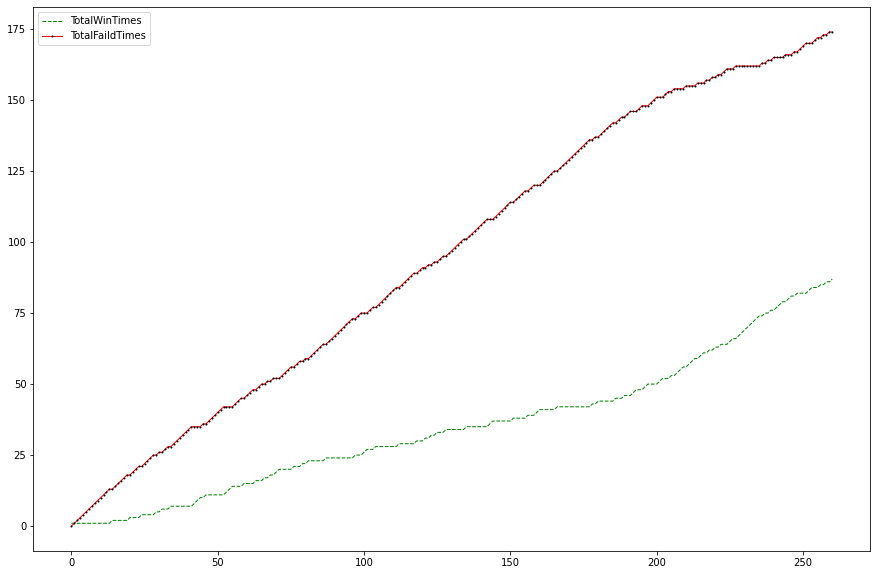

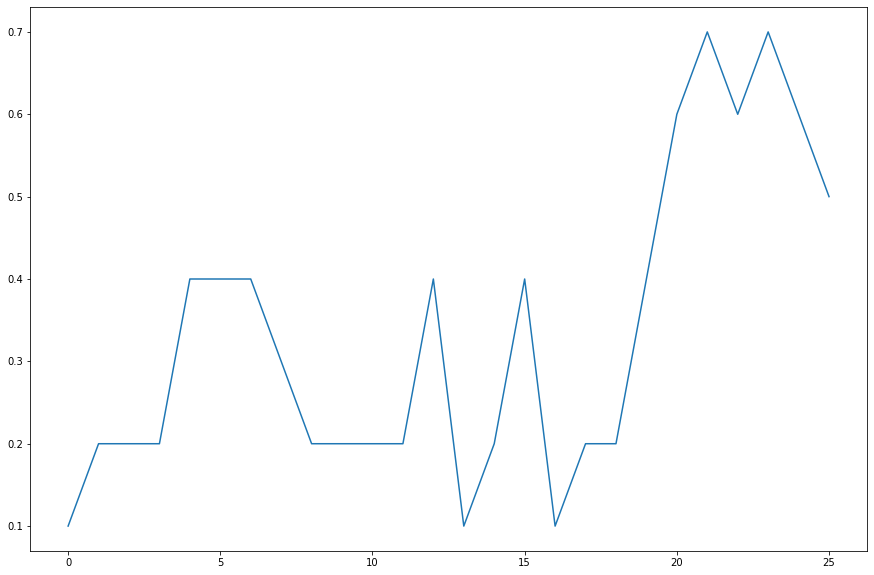


Episode 261 done,Reward = 10.0 mean steps = 13.049618320610687 exp_num = 2500 
epsilon = 0.009999999999982863

Episode 262 done,Reward = -10.0 mean steps = 13.049429657794677 exp_num = 2500 
epsilon = 0.009999999999982863
target_net replaced

Episode 263 done,Reward = -10.0 mean steps = 13.151515151515152 exp_num = 2500 
epsilon = 0.009999999999982863

Episode 264 done,Reward = 10.0 mean steps = 13.124528301886793 exp_num = 2500 
epsilon = 0.009999999999982863

Episode 265 done,Reward = 10.0 mean steps = 13.135338345864662 exp_num = 2500 
epsilon = 0.009999999999982863
target_net replaced
Model Saved

Episode 266 done,Reward = 10.0 mean steps = 13.142322097378278 exp_num = 2500 
epsilon = 0.009999999999982863

Episode 267 done,Reward = -10.0 mean steps = 13.156716417910447 exp_num = 2500 
epsilon = 0.009999999999982863

Episode 268 done,Reward = 10.0 mean steps = 13.118959107806692 exp_num = 2500 
epsilon = 0.009999999999982863


UnityCommunicatorStoppedException: Communicator has exited.

In [5]:
# エージェント作成
agent = DQN(load = False,load_dir="ML-Model/" + "20220205-051103")
# トレーニング済みNNをローディングするにはこちらのコードを使用↓
#agent = DQN(load = True,load_dir="ML-Model/" + "FinalNN-")

total_steps = 0 
steps_list = []
successTimes = 0
failTimes = 0
successTimes_his = []
failTimes_his = []
this10TimesWin = 0
MeanWinPerin10Times = []

for episode in range(EPISODES):
    # episode 開始 
    done = False #ゲーム終了状態をFalse
    steps = 0 
    # 環境初期状態を獲得
    env.reset()
    decision_steps, terminal_steps = env.get_steps(behavior_name)
    state = decision_steps.obs[0]
    state = np.reshape(state, [1, STATE_SIZE])
    
    # ゲームスタート
    while True:
        reward = 0
        steps+=1
        total_steps += 1
        # エージェントナンバーをトラックする
        if tracked_agent == -1 and len(decision_steps) >= 1:
            tracked_agent = decision_steps.agent_id[0]
        
        # REPLACE_STEPS毎でtarget_net にmain_netで入れ替える
        if total_steps % REPLACE_STEPS == 0 and total_steps !=0:
            agent.target_net.set_weights(agent.main_net.get_weights())
            print('target_net replaced')
            
        # SAVE_STEPS毎でNNを保存する
        if total_steps % SAVE_STEPS ==0 and total_steps !=0:
            agent.saveNN()
        
        # main_netで動作選択
        action = agent.select_action(state=state)
        continuous_actions = np.array([[0]], dtype=np.float)
        discrete_actions = np.expand_dims(action,axis=0)
        # 動作をML-Agentsが認識可能なActionTuple型に変換
        action_Tuple = ActionTuple(
            continuous=continuous_actions, discrete=discrete_actions)

        # 動作をゲーム環境に渡す。
        env.set_actions(behavior_name=behavior_name, action=action_Tuple)
        env.step()
        
        # 環境が動作を実行し、次の環境状態を返す。
        decision_steps, terminal_steps = env.get_steps(behavior_name)
        if tracked_agent in decision_steps:  # ゲーム終了していない場合、環境状態がdecision_stepsに保存される
            next_state = decision_steps[tracked_agent].obs[0]
            next_state = np.reshape(next_state,[1,STATE_SIZE])
            reward = decision_steps[tracked_agent].reward
        if tracked_agent in terminal_steps:  # ゲーム終了した場合、環境状態がterminal_stepsに保存される
            next_state = terminal_steps[tracked_agent].obs[0]
            next_state = np.reshape(next_state,[1,STATE_SIZE])
            reward = terminal_steps[tracked_agent].reward
            done = True
        
        # Experience_poolに保存
        agent.exp_pool.add(state,action,reward,next_state,done)
        #print("Reward = ",reward)
        # 環境状態を次状態に変更。
        state = next_state
        
        # ゲーム終了後処理
        if done:
            mean_steps = total_steps/(episode+1)
            print("\nEpisode",episode,"done,Reward =",reward,"mean steps =",mean_steps,"exp_num =",agent.exp_pool.get_len(),"\nepsilon =",agent.epsilon)
            agent.training()
            if(reward >=10):
                successTimes+=1
                this10TimesWin+=1
            else:
                failTimes+=1
            successTimes_his.append(successTimes)
            failTimes_his.append(failTimes)
            if episode % 10 ==0 and episode !=0:
                clear_output()
                this10TimesWinPer = float(this10TimesWin/10)
                this10TimesWin = 0
                MeanWinPerin10Times.append(this10TimesWinPer)
                # 合計成功数(緑)、合計失敗数(赤)を図で表示する
                plt.figure(figsize = (15,10))
                plt.plot(range(len(successTimes_his)), successTimes_his,color='green',linestyle='--', linewidth=1, label='TotalWinTimes')
                plt.plot(range(len(successTimes_his)), failTimes_his,color='red', linewidth=1,marker='o', markersize=1, markerfacecolor='black',markeredgecolor='black',label='TotalFaildTimes')
                # plt.savefig('output.jpg')
                plt.legend()
                plt.savefig("wintimes.png")
                plt.show()
                
                #10回実行した後の成功確率を図で表示する
                plt.figure(figsize=(15,10))
                plt.plot(MeanWinPerin10Times)
                plt.savefig("steps.png")
                plt.show()
            break
env.close()
print("Finished~")